## TP2: Regresión del valor de valor medio de casas en distritos de California (17Co2024)
Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm

### 1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
df_california = fetch_california_housing(as_frame=True).frame
print(df_california.shape)
df_california.head(10)

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


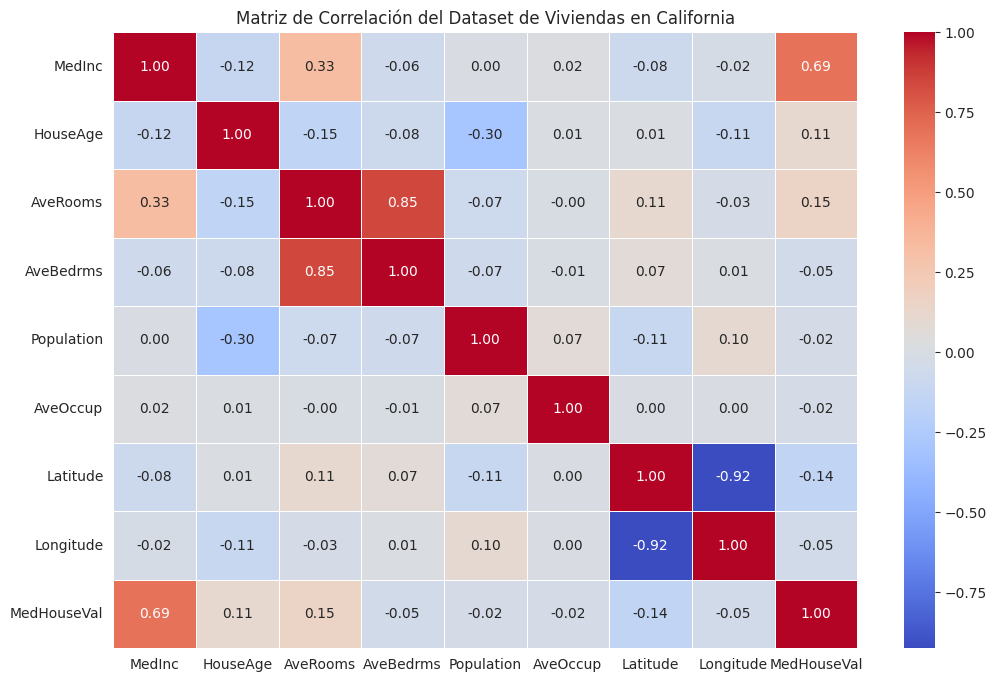

In [2]:
correlation_matrix = df_california.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación del Dataset de Viviendas en California")
plt.show()

#### 1. MedHouseVal
El atributo que tiene mayor correlación con el target es *MedInc*. Esto indica que a medida que aumenta el ingreso medio, tienden a aumentar las casas en ese bloque. El resto de los atributos, no posee una relación fuerte con el target.

#### 2. Otros atributos



*   *AveBedrms* y *AveRooms* tienen una alta correlación entre sí, esto nos dice que a medida que un bloque de casas tiene mas habitaciones, también tiene más dormitorios.
*   *Latitude* y *Longitude* poseen una alta correlación negativa.

En este sentido para eliminar la correlación entre las features podríamos eliminar 1 de cada par que tiene alta correlación entre sí (es decir, podría ser redundante para nuestro modelo).

Lo que sí es de vital importancia hay que notar es que al eliminar un feature del dataset, se debe recalcular la matriz de correlación de los datos (introduciendo quizá en consideración para eliminación ciertas features que en principio no estaban tan correlacionadas)


### 2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

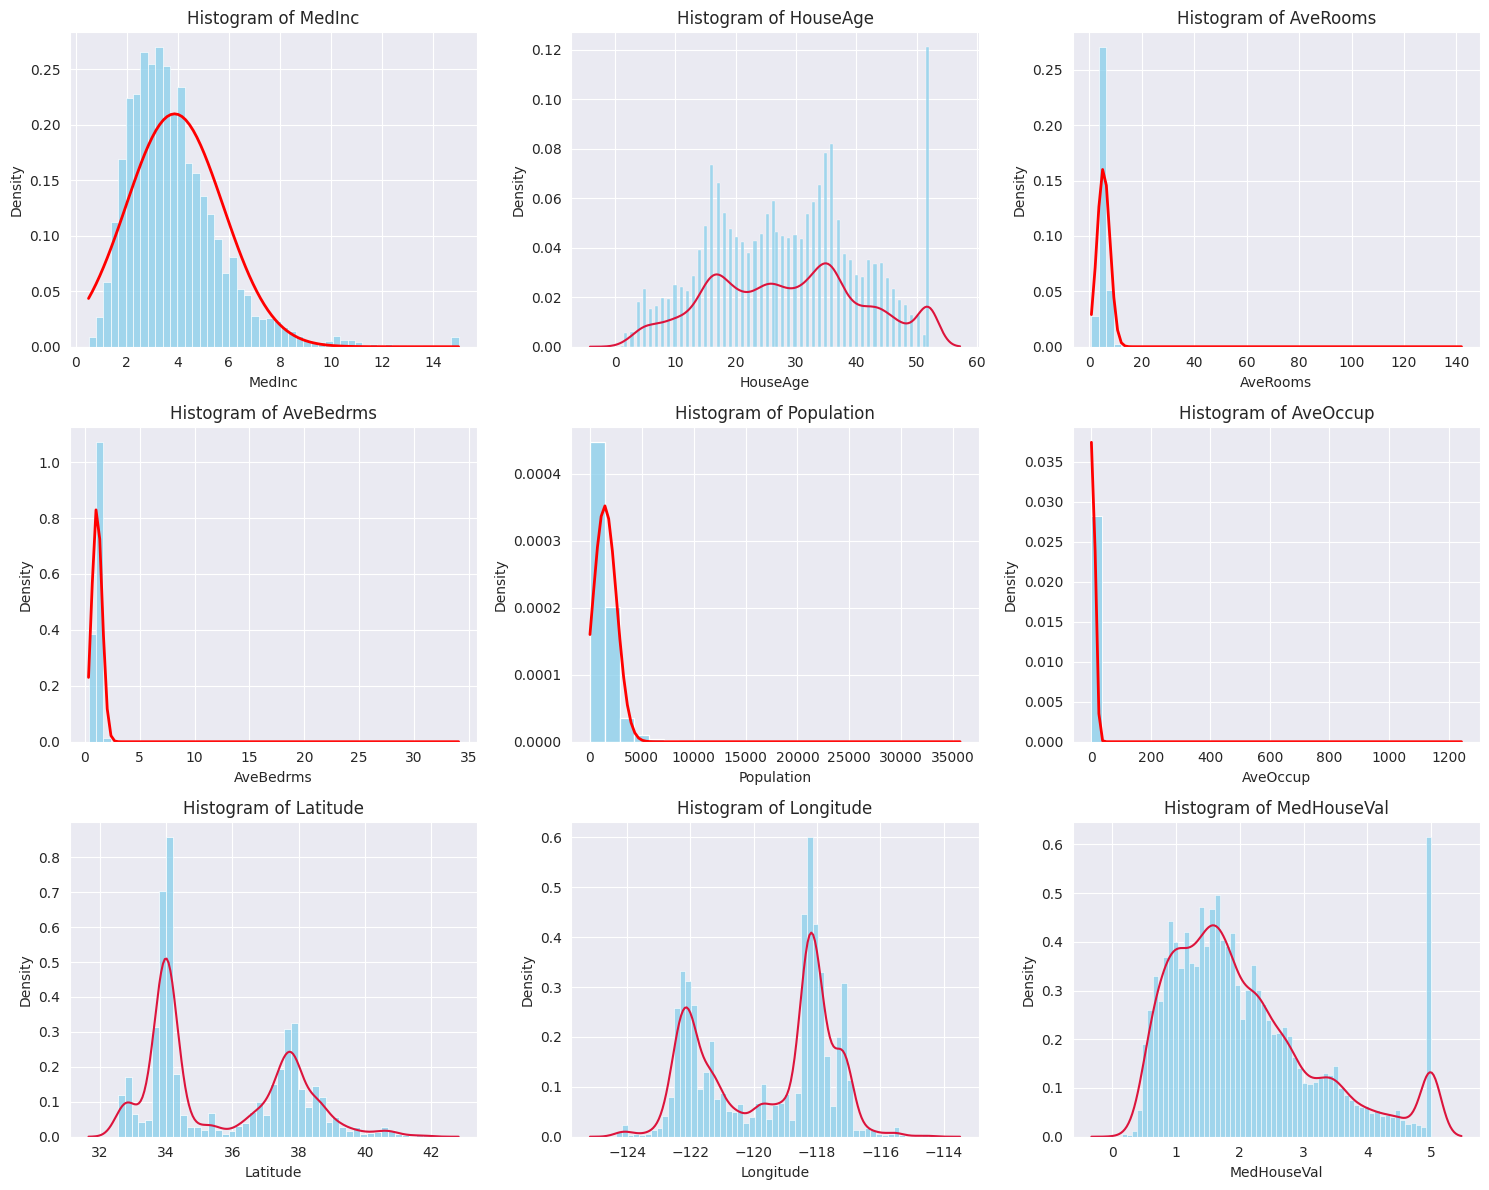

In [3]:
import numpy as np
from scipy.stats import norm
def plot_histogram(df):
    columns_to_plot = df.columns 
    bins_list = [50, 100, 50, 50, 25, 35, 45, 55, 60]  # Customize bins for each plot
    kde_columns = ['HouseAge', 'Latitude' , 'Longitude', 'MedHouseVal'] # these must be estimated by kde
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten() 
    for i, col in enumerate(columns_to_plot):
        sns.histplot(df[col], stat='density', bins=bins_list[i], kde=False, ax=axes[i], color='skyblue')
        
        if col in kde_columns:
            sns.kdeplot(df[col], ax=axes[i], color='crimson')
        else:
            mean = df[col].mean()
            std = df[col].std()
            
            x = np.linspace(df[col].min(), df[col].max(), 100)
            y = norm.pdf(x, mean, std)
            axes[i].plot(x, y, color='red', lw=2)
        
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
plot_histogram(df_california)

A partir de los gráficos podemos concluir:

- En `MedInc, HouseAge, Latitude y Longitude`: La mayoría se podría interpretar como suma de distribuciones gaussianas con distintas medias y desvíos standard.

- Vemos que hay algunos gráficos que tienen un pico pronunciado:
    - En el caso de `MedHouseVal` (que es el target) podemos ver que hay mucha densidad acumulada cerca del 5, esto puede deberse a un valor de saturación en el dataset, es decir que si excede los 500.000 por ejemplo en el caso de que la mediana en el bloque de 650.000, se computa como 500.000.
    - Vemos que en `AveRooms,AveBedrms,Population y AveOccup` tenemos la presencia de outliers, con lo cual no podemos ver en el histograma la verdadera forma de la distribución. Puede haber datos que han sido mal introducidos ya sea por error de tipeo o del sistema, o porque naturalmente existe ese dato.

A modo ilustrativo de cómo se debería limpiar el dataset, se procede a filtrar outliers y valores de saturación:


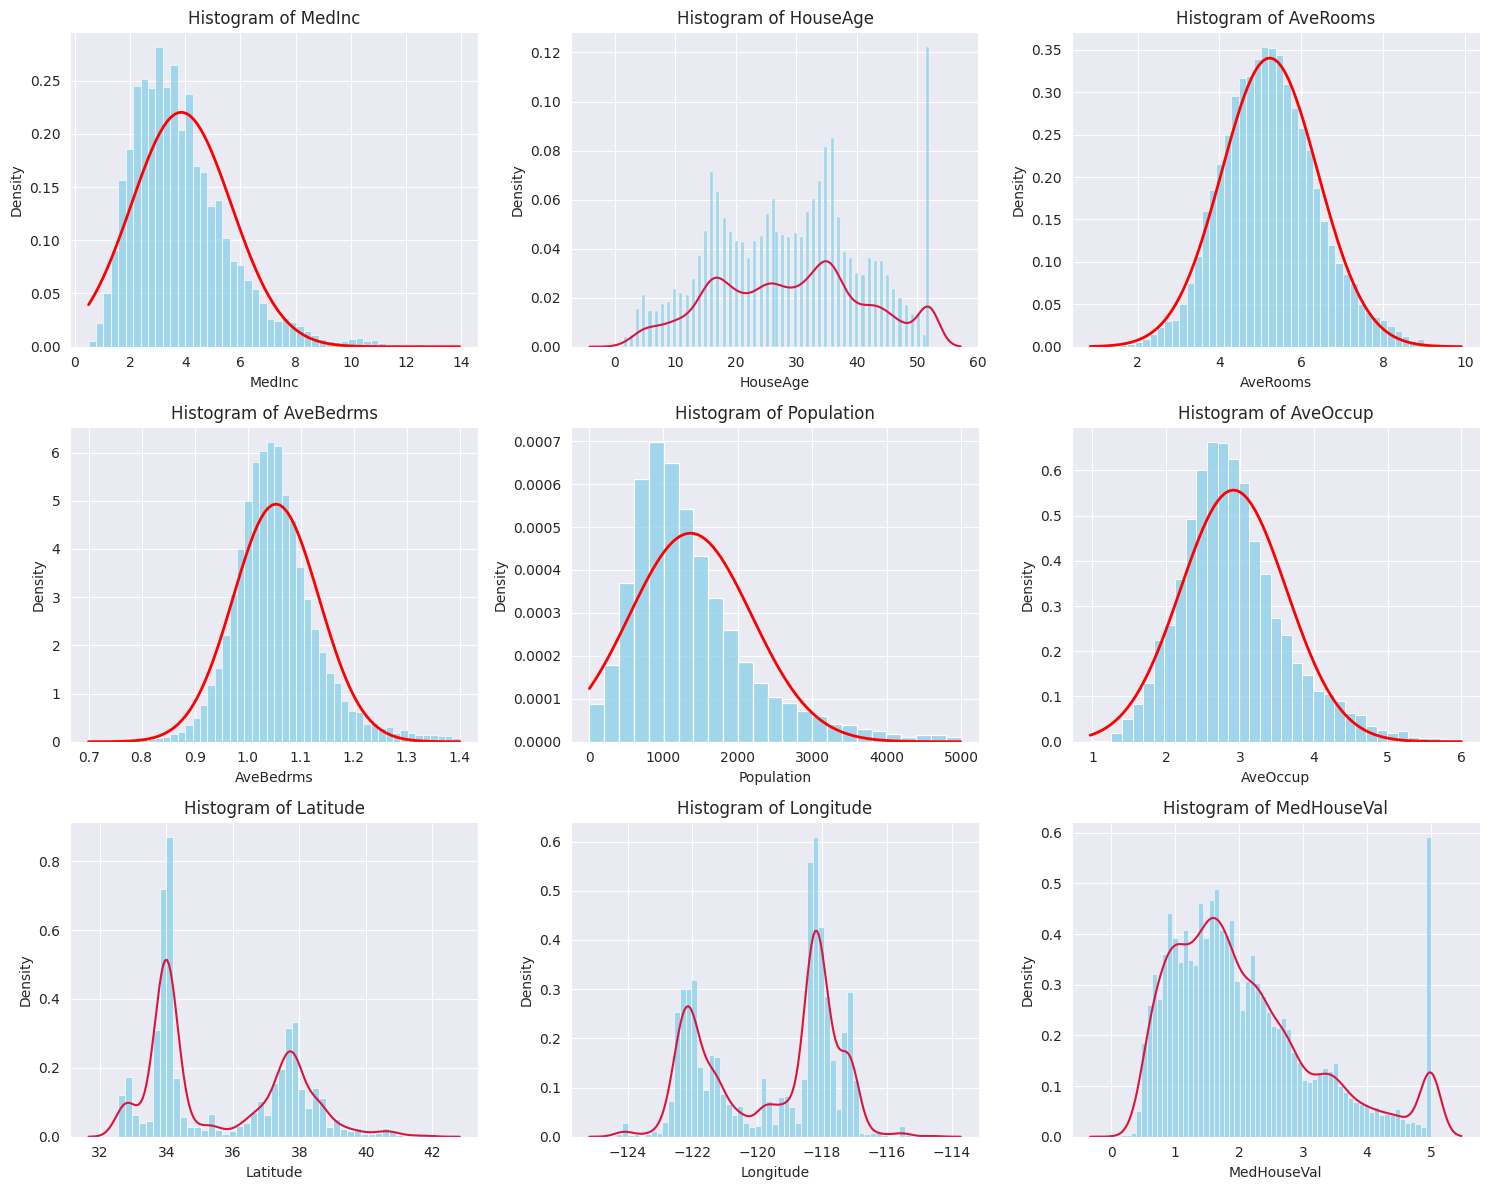

In [4]:
def filter_outliers(df_to_filter):    
    new_df = df_to_filter.copy()
    new_df = new_df[(0 <= new_df["MedInc"]) & (new_df["MedInc"] <= 14)] 
    new_df = new_df[(0 <= new_df["AveRooms"]) & (new_df["AveRooms"] <= 10)] 
    new_df = new_df[(0.7 <= new_df["AveBedrms"]) & (new_df["AveBedrms"] <= 1.4)]
    new_df = new_df[(0 <= new_df["Population"]) & (new_df["Population"] <= 5000)]
    new_df = new_df[(0 <= new_df["AveOccup"]) & (new_df["AveOccup"] <= 6)]
    # new_df = new_df[(0 <= new_df["MedHouseVal"]) & (new_df["MedHouseVal"] <= 4.99999999)]
    return new_df

california_data_wo_outliers = filter_outliers(df_california)
plot_histogram(filter_outliers(df_california))

Aquí se nota con mayor claridad:
 - La verdadera distribución de los datos que tenían outliers (que se trata de una gaussina con una sola media y varianza).
 - Además se puede observar como MedHouseVal va decreciendo su densidad a medida que aumenta el valor, lo cual tiene sentido.

### 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [6]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

# Escalemos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformemos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = lin_reg.predict(X_train_scaled)

y_bar = np.mean(y_train)
y_hat = y_train_pred.copy()

S_e = np.sum((y_train-y_hat)**2)
S_t = np.sum((y_train-y_bar)**2)

S_r = S_t - S_e
print('S_e=', f'{S_e:.2f} - (Residuos)')
print('S_r=', f'{S_r:.2f} - (Parte que explica el modelo)')
print('S_t=', f'{S_t:.2f} - Varianza total')
# S_r, S_e, S_t
N = len(X_train_scaled) # samples
d = len(X_train_scaled.columns) # features

s_e = np.sqrt(S_e/(N-d-1))
print('s_e = ', s_e)

#Coef de Pearson:
R_2 = S_r/S_t
print("R_2=", R_2)


S_e= 7561.47 - (Residuos)
S_r= 11794.46 - (Parte que explica el modelo)
S_t= 19355.93 - Varianza total
s_e =  0.7236600333345641
R_2= 0.6093459727972159


El coeficiente de pearson nos dice que cuanto más cerca de 1 es mejor el ajuste por parte del modelo.

En este caso podríamos argumentar que el coeficiente de pearson no da lo suficientemente cercano a 1. 

En el apartado teórico se menciona que este coeficiente puede dar mal en el caso de que los aparatos de medición sean de mala calidad (ya que aumentan la varianza y no es culpa del modelo), lo cual asumimos que no sucede en este dataset.

Este modelo entonces es malo, esto puede ser debido a que no se hizo una limpieza del dataset como por ejemplo: Eliminar features altamente correlacionadas y outliers. Esto seguramente mejore el modelo bajo la premisa de que si entran datos basura al modelo, sale basura de predicciones.



### 4.  Calcular las métricas de MSE, MAE y R2 del set de evaluación.

In [7]:
y_test_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('mse=', f'{mse:.3g}')
print('mae=', f'{mae:.3g}')
print('r2=', f'{r2:.3g}')

mse= 0.531
mae= 0.527
r2= 0.596


Aquí se puede observar que el MSE y el MAE dan resultados similares.
Como se vió en el apartado teórico, el MSE es sensible a los outliers (debido a que está elevado al cuadrado), es por eso que podríamos pensar que el modelo está haciendo overfitting a los outliers (ya que el error entre el mse y el mae no es tan distinto).

## 5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

best_mse: 0.526817576531949


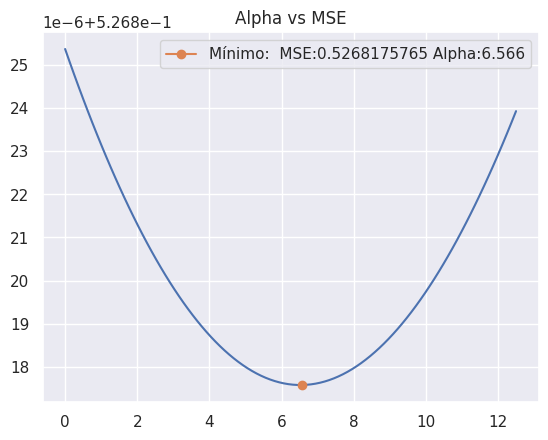

In [8]:
alpha_values = np.linspace(0, 12.5, 100)
MSE = np.array([])
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    mse = -cv.mean()
    MSE = np.append(MSE, mse)

idx = np.argmin(MSE)
best_alpha = alpha_values[idx]
best_mse = MSE[idx]
plt.plot(alpha_values, MSE)
plt.title('Alpha vs MSE')
plt.plot(best_alpha, best_mse, label=f'Mínimo:  MSE:{best_mse:.10g} Alpha:{best_alpha:.4g}', marker='o')
plt.legend()
print('best_mse:', best_mse)

## 6.   Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?



In [9]:
df = pd.DataFrame()
models = []
for name, model in zip(['Ridge', 'Regresión Lineal'],[Ridge(alpha=best_alpha), LinearRegression()]):
    model.fit(X_train_scaled, y_train)
    models.append(model)
    y_test_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    row = {
        'Model': name,
        'MSE': mse,
        'MAE': mae,
    }
    
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df

,Model,MSE,MAE
0,Ridge,0.530415,0.527222
1,Regresión Lineal,0.530568,0.527247


Como se observó en el anterior punto, el MSE es sensible a outliers.
En este caso si bien Ridge obtuvo un menor MSE, obtuvo un mayor MAE.

Esto seguramente tenga que ver con que el Ridge tiende a generalizar más los otros tipos de datos (no outliers).
Tiene sentido ya que a la regresión lineal le agregamos un término de regularización (alpha).
$$
\sum_{i=0}^{N} (y_{[i]} - b - W^T X_{[i]}) + \underbrace{\alpha \sum_{j=0}^{d-1} w_{j}^2}_\text{regularización}
$$

Esta regularización justamente limita el crecimiento de los coeficientes (de esta forma generalizando mejor, evitando overfitting).



### 7. Extra - Datos sin outliers:


droppeamos un 5% del dataset filtrando outliers

In [10]:
california_data_wo_outliers = filter_outliers(df_california)
len(california_data_wo_outliers)

19511

In [11]:
# Transformamos en Pandas
X = pd.DataFrame(california_data_wo_outliers, columns=california_housing['feature_names'])
y = pd.Series(california_data_wo_outliers["MedHouseVal"], name=california_housing['target_names'][0])

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

# Escalemos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformemos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = lin_reg.predict(X_train_scaled)

y_bar = np.mean(y_train)
y_hat = y_train_pred.copy()

S_e = np.sum((y_train-y_hat)**2)
S_t = np.sum((y_train-y_bar)**2)

S_r = S_t - S_e
print('S_e=', f'{S_e:.2f} - (Residuos)')
print('S_r=', f'{S_r:.2f} - (Parte que explica el modelo)')
print('S_t=', f'{S_t:.2f} - Varianza total')
# S_r, S_e, S_t
N = len(X_train_scaled) # samples
d = len(X_train_scaled.columns) # features

s_e = np.sqrt(S_e/(N-d-1))
print('s_e = ', s_e)

#Coef de Pearson:
R_2 = S_r/S_t
print("R_2=", R_2)


S_e= 5618.41 - (Residuos)
S_r= 12251.13 - (Parte que explica el modelo)
S_t= 17869.54 - Varianza total
s_e =  0.6416116542472742
R_2= 0.6855872050708198


In [12]:
y_test_pred = lin_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print('mse=', f'{mse:.3g}')
print('mae=', f'{mae:.3g}')
print('r2=', f'{r2:.3g}')

mse= 0.448
mae= 0.491
r2= 0.663


Podemos observar que todas las métricas mejoraron:

mse= 0.531 -> 0.352

mae= 0.527 -> 0.438

r2= 0.596 -> 0.634

Ahora el MAE supera al MSE.
Esto es debido a que 

$$
MSE = \frac{1}{N} \sum_{i=0}^{N} \underbrace{(y_{[i]} - \hat{y}_{[i]})^2}
$$
Viendo la expresión podemos ver que el error esta elevado al cuadrado.
Si el abs(error) > 1 => MSE es siempre mayor a MAE.
Cuando abs(error) es <1 => el hecho de elevarlo al cuadrado, lo hace más chico a ese término. Por ende en este caso sucede que 
MSE < MAE

 


In [13]:
err = y_test-y_test_pred
list(filter(lambda x: abs(x) <= 1,err))[:5] # quedemos con primeros 5 errores solo para verificar


[-0.28011731585065514,
 0.7783707435703895,
 -0.12910051805835565,
 -0.21233380412649971,
 0.8677072722206418]

best_mse: 0.41234537326476406


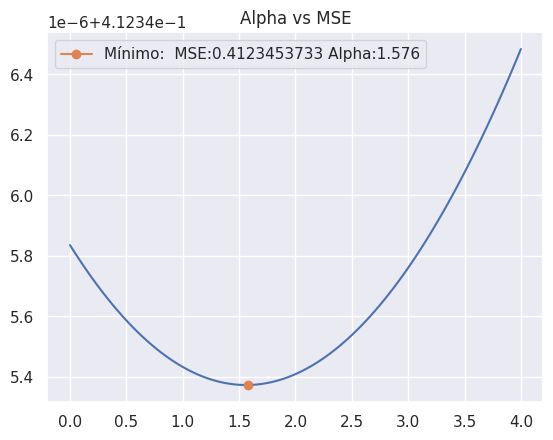

In [14]:
alpha_values = np.linspace(0, 4, 100)
MSE = np.array([])
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    mse = -cv.mean()
    MSE = np.append(MSE, mse)

idx = np.argmin(MSE)
best_alpha = alpha_values[idx]
best_mse = MSE[idx]
plt.plot(alpha_values, MSE)
plt.title('Alpha vs MSE')
plt.plot(best_alpha, best_mse, label=f'Mínimo:  MSE:{best_mse:.10g} Alpha:{best_alpha:.4g}', marker='o')
plt.legend()
print('best_mse:', best_mse)

In [16]:

df = pd.DataFrame()
models = []
for name, model in zip(['Ridge', 'Regresión Lineal'],[Ridge(alpha=best_alpha), LinearRegression()]):
    model.fit(X_train_scaled, y_train)
    models.append(model)
    y_test_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    rmse = root_mean_squared_error(y_test,y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    row = {
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2        
    }
    
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df

,Model,MSE,MAE,RMSE,R2
0,Ridge,0.448247,0.491362,0.669512,0.663107
1,Regresión Lineal,0.448249,0.491382,0.669514,0.663106



En primer lugar con respecto del dataset con outliers también notamos una mejoría en todas las métricas.

En segundo lugar, en este caso Ridge posee mejores métricas que Regresión Lineal, lo cual lo hace un mejor modelo para el dataset sin outliers.